## Getting ready to do some clustering with a neural network of some sort
## I want ground truth clusters that are good, so I'm going to take some of the spectrogram-PCA-UMAP-HDBScan based clusters and clean them up by hand
## Only clusters I manually select will be used in the training dataset.

In [1]:
# from scipy import integrate, optimize

import matplotlib.pyplot as plt
from scipy.signal import spectrogram, butter, sosfilt, sosfiltfilt, correlate
from scipy.io.wavfile import read, write
import IPython.display as ipd
# import sys
from collections import Counter
import os
import pandas as pd
# import pandas as pd
import numpy as np
import matplotlib.colors as mcolors
import pickle
import csv
from soundsig.sound import BioSound 
from soundsig.sound import WavFile

# Dimension reduction and clustering libraries
import umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.decomposition import PCA

/Users/williamwood/Documents/Data/Field Station Recordings/for_soundsep/14_38_03_18_07_2023/_appdata/save/segments.csv
Length of dataframe: 4344
Column names: Index(['Unnamed: 0', 'SourceName', 'SourceChannel', 'StartIndex', 'StopIndex',
       'Tags', 'cluster', 'coords'],
      dtype='object')
Tags: ['["tet"]' '["hat"]' '["3"]' '["call"]' '["DC"]' '["WF"]' '["-2"]' '["8"]'
 '["2"]']
Spectrogram data shape: (4344, 101, 100)


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_62563/3700061290.py:37: UserWarning: shading value '' not in list of valid values ['gouraud', 'nearest', 'flat', 'auto']. Setting shading='auto'.
  plt.pcolormesh(time_bins, freq_bins, spec_data[1,:,:], cmap = 'plasma', shading='')


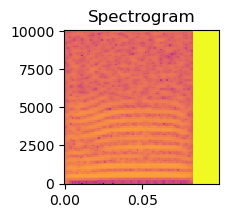

In [2]:
# we have wav files in a folder, H5 files in a folder, and soundsep data. 
# TODO I'm loading too many things right now, I should just load the clustering results and the spectrogram data but for now this is fine.

base_folder = '/Users/williamwood/Documents/Data/Field Station Recordings/for_soundsep/14_38_03_18_07_2023/'

soundsep_file_name = os.path.join(base_folder,'_appdata','save','segments.csv')
wave_files_folder = os.path.join(base_folder,'wavs')
spectrogram_folder = os.path.join(base_folder,'spec_results')

# Load the soundsep data
print(soundsep_file_name)
df = pd.read_csv(soundsep_file_name, sep=',',header=0)        
print(f'Length of dataframe: {len(df)}')
print(f'Column names: {df.columns}')
print(f'Tags: {df["Tags"].unique()}')

# Load the wav filenames to compare with the soundsep data for consistency.
wav_list = [f for f in os.listdir(os.path.join(base_folder,'wavs')) if f.endswith('.wav')]
wav_lengths = [read(os.path.join(base_folder,'wavs',f))[1].shape[0] for f in wav_list]  
shortest_file = wav_list[np.argmin(wav_lengths)]
fs, data = read(os.path.join(base_folder,'wavs', shortest_file))

# Load the spectrogram data to compare with the soundsep data for consistency.
# This also currently has the best clustering results.
cluster_labels = np.load(os.path.join(base_folder,'spec_results','cluster_labels.npy'))

# load the spectrogram datafile
spec_data = np.load(os.path.join(base_folder,'spec_results','spectrograms.npy'))
print(f'Spectrogram data shape: {spec_data.shape}')

# load the times and frequencies for the spectrogram
time_bins = np.load(os.path.join(base_folder,'spec_results','time_bins.npy'))
freq_bins = np.load(os.path.join(base_folder,'spec_results','freq_bins.npy'))

plt.figure(figsize=(2,2))
plt.title('Spectrogram')
plt.pcolormesh(time_bins, freq_bins, spec_data[1,:,:], cmap = 'plasma', shading='')


# ok now we're going to use widgets to pop up spectrograms, a few at a time, and ask the user if they are clean or not.
# but first we have to define what we're looking for

Number of clusters: 7
Cluster 0 has at least 20 members


Cluster 1 has at least 20 members
Cluster 2 has at least 20 members
Cluster 3 has at least 15 members
Cluster 4 has at least 20 members
Cluster 5 has at least 20 members
Cluster 6 has at least 20 members


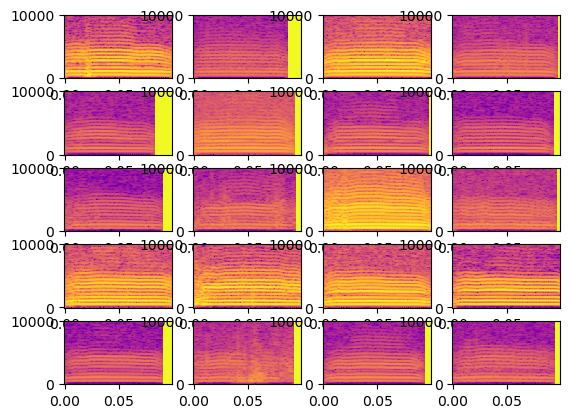

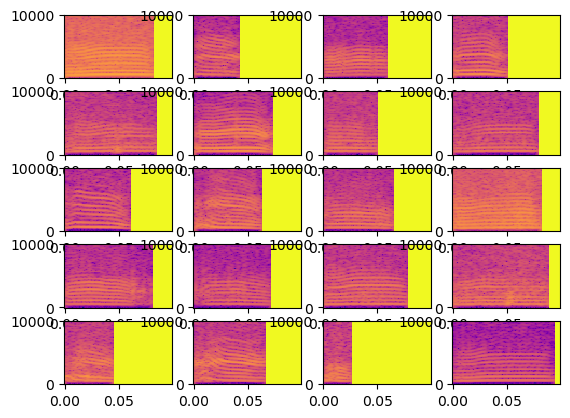

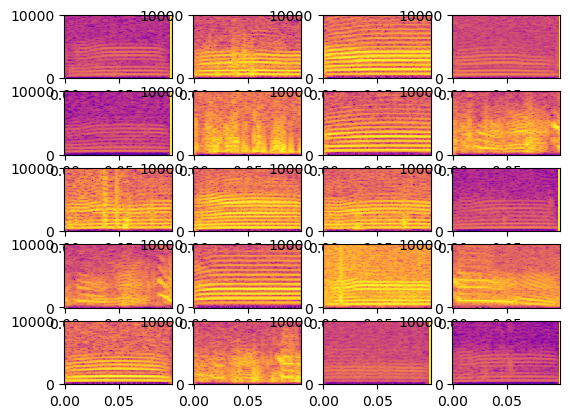

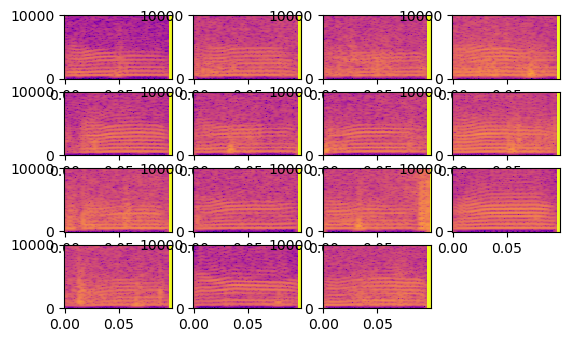

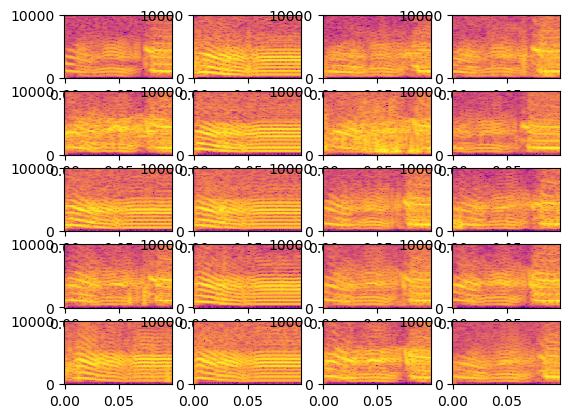

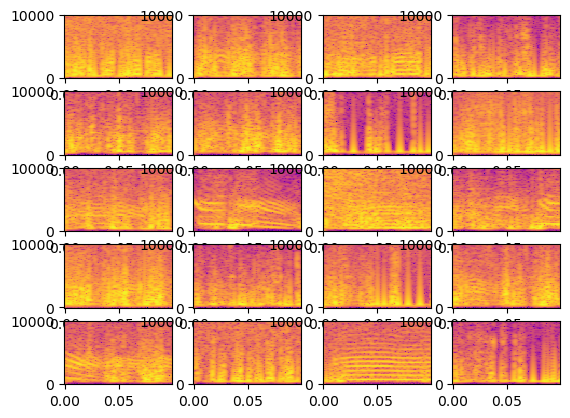

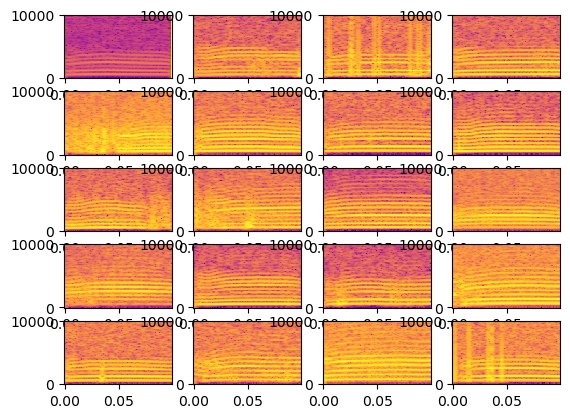

In [3]:
# get the number of clusters
num_clusters = len(np.unique(cluster_labels))
print(f'Number of clusters: {num_clusters}')
# loop through the clusters and plot the first 20 spectrograms from each cluster using the index from the original data
for i in range(num_clusters):
    clusterInd = np.where(cluster_labels == i)
    if len(clusterInd[0]) > 20:
        clusterInd = clusterInd[0][:20]
    else:
        clusterInd = clusterInd[0]
    plt.figure()
    print(f'Cluster {i} has at least {len(clusterInd)} members')
    for j, ind in enumerate(clusterInd):
        plt.subplot(5,4,j+1)
        plt.pcolormesh(time_bins, freq_bins, spec_data[ind,:,:], cmap='plasma', shading='auto')

Dataframe length matches wav file length
Dataframe length matches cluster label length


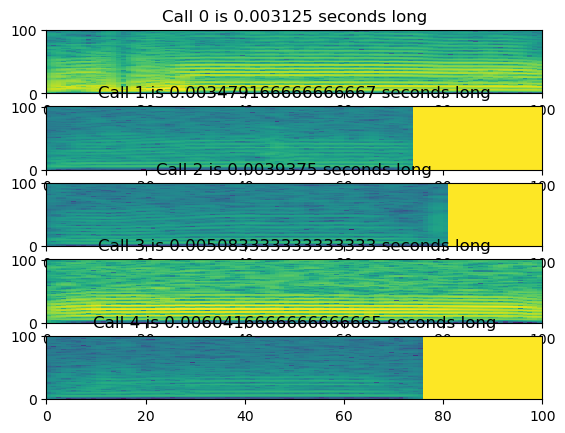

In [4]:
# let's at least make sure the wav files are in the same order as the soundsep data
# we'll just check that the lengths of the wav files are the same as the lengths of the soundsep data
# and that the names are the same (maybe) 
# and that the spectrogram data is the same length as the soundsep data (maybe)

if len(df) != len(wav_list):
    print('Dataframe length does not match wav file length')
    print(f'Length of dataframe: {len(df)}')
    print(f'Length of wav files: {len(wav_list)}')
else:
    print('Dataframe length matches wav file length')

if len(df) != len(cluster_labels):
    print('Dataframe length does not match cluster label length')
    print(f'Length of dataframe: {len(df)}')
    print(f'Length of cluster labels: {len(cluster_labels)}')
else:
    print('Dataframe length matches cluster label length')

# we can quickly plot the shortest spectrograms, based on the shortest entries in the dataframe
# which should convince us that the data is in the right order
call_lengths = df['StopIndex'] - df['StartIndex']
call_lengths /= fs
# df['CallLength'] = call_lengths
# get the index order of the shortest calls
shortest_calls = call_lengths.sort_values().index


# plot the shortest calls
for i in range(5):
    plt.subplot(5,1,i+1)
    plt.pcolormesh(spec_data[shortest_calls[i],:,:])
    plt.title(f'Call {i} is {call_lengths[shortest_calls[i]]} seconds long')

# df.sort_values('CallLength', inplace=False)


call lengths surround shortest call are 0.15364583333333334, 0.003125, and 0.09195833333333334


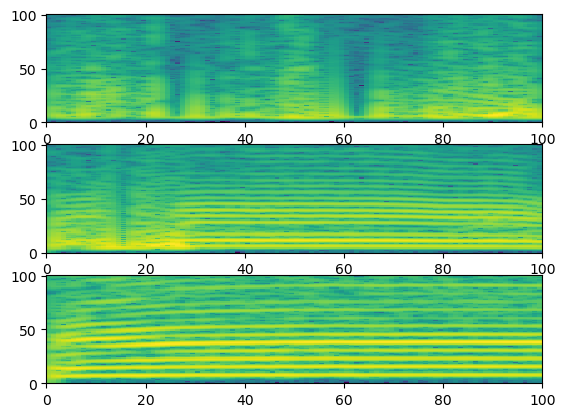

In [5]:
a = shortest_calls[0]
print(f'call lengths surround shortest call are {call_lengths[a-1]}, {call_lengths[a]}, and {call_lengths[a+1]}')
plt.figure()
plt.subplot(3,1,1)  
plt.pcolormesh(spec_data[a-1,:,:])
plt.subplot(3,1,2)
plt.pcolormesh(spec_data[a,:,:])
plt.subplot(3,1,3)
plt.pcolormesh(spec_data[a+1,:,:])

In [6]:
call_lengths[shortest_calls[0:10]]

2383    0.003125
252     0.003479
719     0.003938
1443    0.005083
3820    0.006042
254     0.011667
715     0.015729
2726    0.022000
352     0.023938
3899    0.025604
dtype: float64

# NOT GOOD THESE SPECTROGRAMS DON't look to be in ther right order
# ok so in my save_spectrograms notebook the indexes that correspond to the spectrograms being the right lenght are different from these indices. 
# those lengths are calculated based on the lengths of the sounds in the H5 files.
# these lengths are based on the calculated call lengths in the df.


In [7]:
# calculate the call lengths based on the H5 data
os.chdir(os.path.join(base_folder,'h5filesAmp'))
h5_files = [f for f in os.listdir() if f.endswith('.h5')]
lengths = list()
for fname in h5_files:
    myBioSound = BioSound()
    myBioSound.readh5(fname)
    lengths.append(len(myBioSound.sound))

# index the shortest calls in lengths
shortest_calls_h5 = np.argsort(lengths)
shortest_calls_h5[:10]

array([1820, 2214, 2247, 4091, 4201, 1140, 1793,  960, 1719,  766])

# ok these are right, so actually my DF might be out of order, ack.

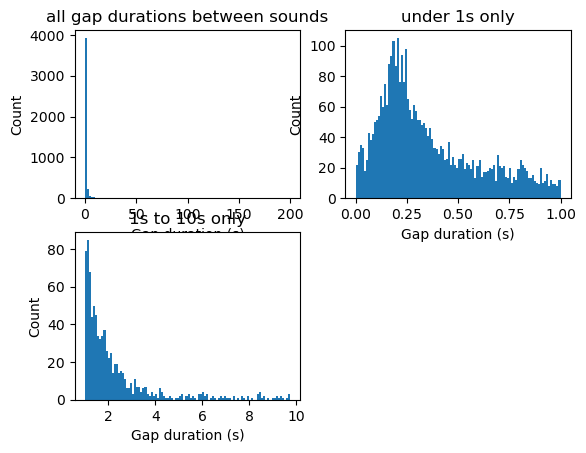

In [8]:
# calculate the gap durations between each sound
# we'll use the soundsep data for this
# df['StartIndex'][0]
df['gap_duration'] = df['StartIndex'].diff()
df['gap_duration'] /= fs

# plot a histogram of the gap durations

plt.figure()
plt.subplot(2,2,1)
plt.hist(df['gap_duration'], bins=100)
plt.xlabel('Gap duration (s)')
plt.ylabel('Count')
plt.title('all gap durations between sounds')

# plot a histogram of the gap durations zoomed in on the short gaps
# take the gap_durations that are less than 1 second and put them in a variable to make a histogram
short_gap_index = (df['gap_duration'] < 1).values
short_gaps = df['gap_duration'][short_gap_index]
plt.subplot(2,2,2)
plt.hist(short_gaps, bins=100)
plt.xlabel('Gap duration (s)')
plt.ylabel('Count')
plt.title('under 1s only')

medium_gap_index = (df['gap_duration'] > 1) & (df['gap_duration'] < 10)
medium_gaps = df['gap_duration'][medium_gap_index]
plt.subplot(2,2,3)
plt.hist(medium_gaps, bins=100)
plt.xlabel('Gap duration (s)')
plt.ylabel('Count')
plt.title('1s to 10s only')
plt.show()

# Ok that's surprisingly interesting already.
## The next step is probably to break this down more by bird and by call type
## My clusters aren't very accurate. I would like to make them much better using a RNN on the spectrograms, which is what I am going to spend this afternoon trying to make
